<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [301]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

Reading original data

In [334]:
PATH_TO_DATA = ('../../../data/catch_me_if_you_can')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [335]:
def df_to_correct_types(df, fmt='%Y-%m-%d %H:%M:%S', dt_prefix='time'):
    for clmn in df.columns:
        if (clmn.startswith(dt_prefix)):
            df[clmn] = pd.to_datetime(df[clmn], format=fmt, errors='ignore')
        elif df[clmn].dtype == 'float64':
            df[clmn] = df[clmn].fillna(0).astype('int64')

In [336]:
df_to_correct_types(train_df)
df_to_correct_types(test_df)

# train_df = train_df.fillna(0)
# test_df = test_df.fillna(0)

Separate target feature 

In [337]:
y = train_df['target']

TypeError: ufunc multiply cannot use operands with types dtype('<M8[ns]') and dtype('int32')

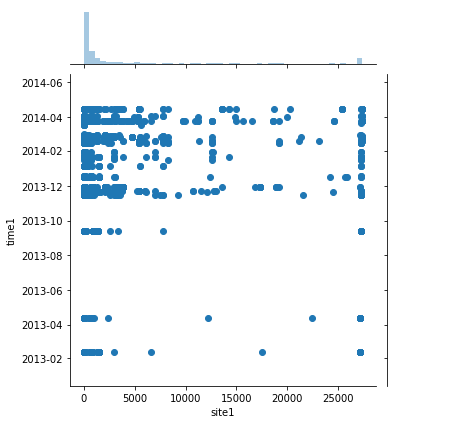

In [343]:
sns.jointplot(x=train_df[train_df.target == 1].site1, y=train_df[train_df.target == 1].time1)

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

In [306]:

strings = train_df[train_df.columns[train_df.columns.str.startswith('site')]].astype('str').apply(lambda x: ' '.join(x), axis=1)
strings_test = test_df[test_df.columns[test_df.columns.str.startswith('site')]].astype('str').apply(lambda x: ' '.join(x), axis=1)
all_strings = pd.concat([strings, strings_test])
# tfidf_sites = tfidf.fit(all_strings)

from sklearn.feature_extraction.text import CountVectorizer

sites = ['site%s' % i for i in range(1, 11)]
s1_fl_0 = pd.Series(train_df[(train_df.target == 0)][sites].values.flatten())
s1_fl_1 = pd.Series(train_df[(train_df.target == 1)][sites].values.flatten())
top_0 = s1_fl_0.value_counts().sort_values(ascending=False)[:3000]
top_1 = s1_fl_1.value_counts().sort_values(ascending=False)[:2000]
top_sites = top_0.index.union(top_1.index)

# trans = CountVectorizer(ngram_range=(1,4), max_features=100000, vocabulary=top_sites, token_pattern='(?u)\b\w+\b')
trans = TfidfVectorizer(ngram_range=(1, 3), max_features=100000)

vect_fit = trans.fit(list(all_strings))

In [307]:
# tfidf_ = tfidf_sites
# tfidf_sites = tfidf_.transform(strings)
# tfidf_sites_test = tfidf_.transform(strings_test)

vect_sites = vect_fit.transform(strings)
vect_sites_test = vect_fit.transform(strings_test)

In [308]:
vect_sites.shape

(253561, 100000)

Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [309]:
def add_time_features(df):
    for cl in [clmn for clmn in df.columns if clmn.startswith('time')]:
        df[cl+'_year'] = df[cl].dt.year
        df[cl + '_month'] = df[cl].dt.month
        df[cl + '_after_2013_11'] = (df[cl] > pd.Timestamp('2013-11-01')).astype('int')
        wd = df[cl].dt.dayofweek
        df[cl + '_weekday'] = wd
        df[cl + '_is_weekend'] = (df[cl].dt.dayofweek >= 5).astype('int64')
#         wd_dumm = pd.get_dummies(wd, prefix=[cl +'_weekday'])
#         df[wd_dumm.columns] = wd_dumm
#         df[cl + '_month'] = df[cl].dt.month
#         df[cl + '_season'] = (((df[cl].dt.month % 12) / 3) + 1).fillna(0).astype('int64')
        
        hour = df[cl].dt.hour
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        night = ((hour >= 0) & (hour <= 6)).astype('int')

        df[cl + '_morning'] = morning
        df[cl + '_day'] = day
        df[cl + '_evening'] = evening
        df[cl + '_night'] = night


In [310]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     82797 non-null int64
time2     81308 non-null datetime64[ns]
site3     82797 non-null int64
time3     80075 non-null datetime64[ns]
site4     82797 non-null int64
time4     79182 non-null datetime64[ns]
site5     82797 non-null int64
time5     78341 non-null datetime64[ns]
site6     82797 non-null int64
time6     77566 non-null datetime64[ns]
site7     82797 non-null int64
time7     76840 non-null datetime64[ns]
site8     82797 non-null int64
time8     76151 non-null datetime64[ns]
site9     82797 non-null int64
time9     75484 non-null datetime64[ns]
site10    82797 non-null int64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), int64(10)
memory usage: 13.3 MB


In [311]:
add_time_features(train_df)
add_time_features(test_df)

In [312]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Columns: 111 entries, site1 to time10_night
dtypes: datetime64[ns](10), float64(27), int32(50), int64(24)
memory usage: 168.3 MB


In [313]:
def add_site_features(df):
    for st in sites:
        df[st + '_gt25000'] = (df[st] > 25000).astype('int')
        df[st + '_gt13000'] = ((df[st] <= 25000) & (df[st] > 13000)).astype('int')
        df[st + '_lt13000'] = (df[st]<=13000).astype('int')
    
#     for i in range(1, 10):
#         df['site' + str(i) + '_duration'] = (df['time' + str(i+1)] - df['time' + str(i)]).dt.seconds

    

In [314]:
add_site_features(train_df)
add_site_features(test_df)

In [315]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Columns: 141 entries, site1 to site10_lt13000
dtypes: datetime64[ns](10), float64(27), int32(80), int64(24)
memory usage: 197.3 MB


In [316]:

s1_fl_1 = pd.Series(train_df[(train_df.target == 1)][sites].values.flatten())
top_1 = s1_fl_1.value_counts().sort_values(ascending=False)[:20]


s1_fl_0 = pd.Series(train_df[(train_df.target == 0)][sites].values.flatten())
top_0 = s1_fl_0.value_counts().sort_values(ascending=False)[:20]

for st in sites:
    top1_st =  train_df[(train_df.target == 1)][st].value_counts().sort_values(ascending=False)[:10]
    train_df[st + '_top1'] = train_df[st].isin(top1_st[:10]).astype('int')
    
    test_df[st + '_top1'] = test_df[st].isin(top1_st[:10]).astype('int')

In [317]:
dt_init = train_df.select_dtypes(include=['datetime64'])
train_df = train_df.drop(list(dt_init.columns), axis=1)

In [318]:
dt_init_test = test_df.select_dtypes(include=['datetime64'])
test_df = test_df.drop(list(dt_init_test.columns), axis=1)

In [319]:
sites_init = train_df.iloc[:, :10]
train_df = train_df.drop(list(sites_init.columns), axis=1)

In [320]:
sites_init_test = test_df.iloc[:, :10]
test_df = test_df.drop(list(sites_init_test.columns), axis=1)

In [321]:
train_df = train_df.drop(['target'], axis=1)

Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [322]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

std_sc = StandardScaler().fit(train_df)
train_df = std_sc.transform(train_df)
test_df = std_sc.transform(test_df)


In [323]:

tf_train_df = hstack([vect_sites, train_df])
tf_test_df = hstack([vect_sites_test, test_df])
# tf_train_df = train_df
# tf_test_df = test_df

In [324]:
tf_train_df.shape

(253561, 100130)

In [325]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
time_split = TimeSeriesSplit(n_splits=5)

Perform cross-validation with logistic regression.

In [326]:
logreg= LogisticRegression(C=1.67, random_state=11)
cv_scores = cross_val_score(logreg, tf_train_df, list(y), cv=time_split, 
                            scoring='roc_auc', n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


In [327]:
cv_scores

array([0.94633538, 0.95674221, 0.97159188, 0.96728886, 0.97258182])

In [269]:
c_values = np.logspace(-2, 2, 5)

logit_grid_searcher = GridSearchCV(estimator=logreg, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5), verbose=2)

In [270]:
%%time
logit_grid_searcher.fit(tf_train_df, list(y))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.6min finished


Wall time: 8min 16s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=11, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [271]:
logit_grid_searcher.best_params_, logit_grid_searcher.best_score_

({'C': 1.6681005372000592}, 0.8572153475398341)

In [232]:
logit_grid_searcher.cv_results_

{'mean_fit_time': array([ 31.72671452,  58.07504611,  57.96092873, 162.31611342,
        207.12239294, 340.76732326, 624.4794199 , 460.33005352,
        465.27782097, 454.10528693]),
 'mean_score_time': array([0.07118044, 0.10820131, 0.08304052, 0.08020077, 0.08850131,
        0.09790063, 0.11092105, 0.10066071, 0.10726066, 0.11396036]),
 'mean_test_score': array([0.90246558, 0.91830937, 0.93403857, 0.94873372, 0.96077879,
        0.96878749, 0.97307342, 0.97372334, 0.97333363, 0.97393039]),
 'mean_train_score': array([0.90775176, 0.92514276, 0.94307127, 0.96110045, 0.97663749,
        0.98919126, 0.99666764, 0.99755445, 0.99624655, 0.99719409]),
 'param_C': masked_array(data=[0.01, 0.027825594022071243, 0.0774263682681127,
                    0.21544346900318834, 0.5994842503189409,
                    1.6681005372000592, 4.6415888336127775,
                    12.915496650148826, 35.93813663804626, 100.0],
              mask=[False, False, False, False, False, False, False, False,
  

In [48]:
y_pred_cv = logit_grid_searcher.predict_proba(tf_test_df)[:, 1]
write_to_submission_file(y_pred_cv, "assignment6_alice_submission3_cv.csv")

In [49]:
y_pred_cv

array([8.34818755e-05, 2.01075180e-06, 2.68266015e-05, ...,
       4.04786459e-05, 9.72001184e-06, 1.02352137e-05])

In [118]:
logit = LogisticRegression(C=logreg.C_[0], random_state=11, n_jobs=-1, verbose=2)
logit.fit(tf_train_df, list(y))

[LibLinear]

LogisticRegression(C=21.54434690031882, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=11,
          solver='liblinear', tol=0.0001, verbose=2, warm_start=False)

In [122]:
y_tr_pred = logit.predict(tf_train_df)
roc_auc_score(list(y), y_tr_pred)

0.9004607324436003

In [150]:
y_pred_tf = logreg.predict(tf_train_df)
roc_auc_score(y_pred_tf, list(y))

NotFittedError: This LogisticRegression instance is not fitted yet

In [328]:
logreg.fit(tf_train_df, list(y))

LogisticRegression(C=1.67, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=11, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [329]:
y_tr_pred = logreg.predict_proba(tf_train_df)[:, 1]
roc_auc_score(list(y), y_tr_pred)

0.9885185551914822

In [237]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

max_depth_values = [None]
max_features_values = range(20, tf_train_df.shape[1], 20)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

rf_gs = GridSearchCV(RandomForestClassifier(random_state=11), forest_params, cv=time_split, verbose=2, n_jobs=-1, scoring='roc_auc')

In [238]:
rf_gs.fit(tf_train_df, list(y))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.0min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=11, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [None], 'max_features': range(20, 199, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [239]:
rf_gs.best_params_, rf_gs.best_score_

({'max_depth': None, 'max_features': 40}, 0.7593963582158639)

Make prediction for the test set and form a submission file.

In [330]:
test_pred = logreg.predict_proba(tf_test_df)[:, 1]

In [331]:
test_pred

array([3.20312899e-04, 2.81019752e-05, 8.00377600e-03, ...,
       1.39023533e-04, 1.74002930e-05, 9.23024246e-05])

In [332]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [333]:
write_to_submission_file(test_pred, "assignment6_alice_submission_less_f.csv")

In [ ]:
test_df